# 📊 Cotton Candy Quality Score Comparative Analysis

## 🎯 Objective
This notebook performs a comprehensive comparative analysis of the `my_score` parameter across different data subsets to understand how model performance and insights change with:
- **Recent data subsets**: Last 40, 60, 80, 100 iterations
- **Historical data subsets**: First 40, 60, 80, 100 iterations

## 🔬 Research Questions
1. **How does model performance change with different sample sizes?**
2. **Are there different patterns in recent vs historical data?**
3. **Which controllable parameters show consistent importance across subsets?**
4. **How do environmental factors impact quality differently over time?**
5. **What is the optimal sample size for reliable analysis?**

## 📊 Step 1: Setup and Data Loading

We'll load the data and set up our analysis framework for multiple subset comparisons.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

# Load the complete cotton candy dataset
csv_path = 'Data Analysis/Complete_cc_dataset.csv'
df = pd.read_csv(csv_path, delimiter=';')

print(f"📊 Original dataset loaded: {len(df)} samples")

# Define our variables of interest
environmental_vars = [
    'baseline_env_EnvH', 'baseline_env_EnvT',
    'before_turn_on_env_InH', 'before_turn_on_env_InT', 
    'before_turn_on_env_IrO', 'before_turn_on_env_IrA'
]

controllable_vars = [
    'iteration_since_maintenance', 'cook_time', 'start_temp', 'cook_temp'
]

target_var = 'my_score'
all_vars = environmental_vars + controllable_vars + [target_var]

# Clean the base dataset
analysis_df = df[all_vars + ['iteration']].copy()
clean_base_df = analysis_df.dropna(subset=all_vars).copy()

# Convert data types
for col in all_vars:
    clean_base_df[col] = pd.to_numeric(clean_base_df[col], errors='coerce')

clean_base_df = clean_base_df.dropna(subset=all_vars)
clean_base_df = clean_base_df.sort_values('iteration')

print(f"📊 Clean base dataset: {len(clean_base_df)} usable samples")
print(f"📊 Iteration range: {clean_base_df['iteration'].min():.0f} to {clean_base_df['iteration'].max():.0f}")

# Define subset sizes to analyze
subset_sizes = [40, 60, 80, 100]
print(f"\n🔬 Will analyze subsets of sizes: {subset_sizes}")
print(f"📈 Recent data: Last N iterations")
print(f"📉 Historical data: First N iterations")

📊 Original dataset loaded: 174 samples
📊 Clean base dataset: 141 usable samples
📊 Iteration range: 0 to 174

🔬 Will analyze subsets of sizes: [40, 60, 80, 100]
📈 Recent data: Last N iterations
📉 Historical data: First N iterations


## 🔧 Step 2: Analysis Framework

We'll create functions to perform the analysis on each data subset and collect results for comparison.

In [2]:
def analyze_subset(data_subset, subset_name, subset_size, data_type):
    """
    Perform complete analysis on a data subset
    """
    results = {
        'name': subset_name,
        'size': subset_size,
        'type': data_type,  # 'recent' or 'historical'
        'n_samples': len(data_subset)
    }
    
    if len(data_subset) < 10:  # Need minimum samples for analysis
        results['error'] = 'Insufficient data'
        return results
    
    try:
        # Basic statistics
        results['target_mean'] = data_subset[target_var].mean()
        results['target_std'] = data_subset[target_var].std()
        results['target_range'] = data_subset[target_var].max() - data_subset[target_var].min()
        
        # Correlation analysis
        correlations = {}
        env_correlations = []
        control_correlations = []
        
        for var in environmental_vars:
            if var in data_subset.columns:
                corr = data_subset[var].corr(data_subset[target_var])
                correlations[var] = corr
                env_correlations.append(abs(corr))
        
        for var in controllable_vars:
            if var in data_subset.columns:
                corr = data_subset[var].corr(data_subset[target_var])
                correlations[var] = corr
                control_correlations.append(abs(corr))
        
        results['correlations'] = correlations
        results['avg_env_correlation'] = np.mean(env_correlations) if env_correlations else 0
        results['avg_control_correlation'] = np.mean(control_correlations) if control_correlations else 0
        
        # Find strongest correlations
        sorted_corrs = sorted(correlations.items(), key=lambda x: abs(x[1]), reverse=True)
        results['strongest_factor'] = sorted_corrs[0][0] if sorted_corrs else None
        results['strongest_correlation'] = sorted_corrs[0][1] if sorted_corrs else 0
        
        # Machine learning models
        feature_vars = environmental_vars + controllable_vars
        X = data_subset[feature_vars]
        y = data_subset[target_var]
        
        # Handle train/test split based on sample size
        if len(X) >= 20:
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
        else:
            X_train, X_test, y_train, y_test = X, X, y, y
        
        # Random Forest Model
        rf_model = RandomForestRegressor(n_estimators=50, random_state=42)  # Reduced trees for small datasets
        rf_model.fit(X_train, y_train)
        rf_pred = rf_model.predict(X_test)
        results['rf_r2'] = r2_score(y_test, rf_pred)
        results['rf_rmse'] = np.sqrt(mean_squared_error(y_test, rf_pred))
        
        # Feature importance
        feature_importance = dict(zip(feature_vars, rf_model.feature_importances_))
        results['feature_importance'] = feature_importance
        
        # Top environmental and controllable factors
        env_importance = {k: v for k, v in feature_importance.items() if k in environmental_vars}
        control_importance = {k: v for k, v in feature_importance.items() if k in controllable_vars}
        
        results['top_env_factor'] = max(env_importance, key=env_importance.get) if env_importance else None
        results['top_control_factor'] = max(control_importance, key=control_importance.get) if control_importance else None
        
        results['env_importance_total'] = sum(env_importance.values())
        results['control_importance_total'] = sum(control_importance.values())
        
        # Linear Regression for comparison
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        lr_model = LinearRegression()
        lr_model.fit(X_train_scaled, y_train)
        lr_pred = lr_model.predict(X_test_scaled)
        results['lr_r2'] = r2_score(y_test, lr_pred)
        results['lr_rmse'] = np.sqrt(mean_squared_error(y_test, lr_pred))
        
        results['success'] = True
        
    except Exception as e:
        results['error'] = str(e)
        results['success'] = False
    
    return results

print("✅ Analysis framework ready")

✅ Analysis framework ready


## 🔬 Step 3: Run Comprehensive Analysis

We'll analyze all subsets and collect results for comparison.

In [3]:
# Run analysis for all subsets
all_results = []

print("🔬 RUNNING COMPREHENSIVE ANALYSIS")
print("=" * 50)

# Recent data analysis (last N iterations)
print("\n📈 ANALYZING RECENT DATA (Last N iterations):")
for size in subset_sizes:
    print(f"\n📊 Processing last {size} iterations...")
    
    recent_subset = clean_base_df.sort_values('iteration', ascending=False).head(size)
    
    subset_name = f"Last {size}"
    results = analyze_subset(recent_subset, subset_name, size, 'recent')
    all_results.append(results)
    
    if results.get('success', False):
        print(f"  ✅ Success: {results['n_samples']} samples, RF R²: {results['rf_r2']:.3f}")
        print(f"      Target mean: {results['target_mean']:.2f} ± {results['target_std']:.2f}")
        print(f"      Strongest factor: {results['strongest_factor']} (r={results['strongest_correlation']:+.3f})")
    else:
        print(f"  ❌ Error: {results.get('error', 'Unknown error')}")

# Historical data analysis (first N iterations)
print("\n📉 ANALYZING HISTORICAL DATA (First N iterations):")
for size in subset_sizes:
    print(f"\n📊 Processing first {size} iterations...")
    
    historical_subset = clean_base_df.sort_values('iteration', ascending=True).head(size)
    
    subset_name = f"First {size}"
    results = analyze_subset(historical_subset, subset_name, size, 'historical')
    all_results.append(results)
    
    if results.get('success', False):
        print(f"  ✅ Success: {results['n_samples']} samples, RF R²: {results['rf_r2']:.3f}")
        print(f"      Target mean: {results['target_mean']:.2f} ± {results['target_std']:.2f}")
        print(f"      Strongest factor: {results['strongest_factor']} (r={results['strongest_correlation']:+.3f})")
    else:
        print(f"  ❌ Error: {results.get('error', 'Unknown error')}")

print(f"\n🎉 Analysis complete! Analyzed {len(all_results)} subsets")

# Filter successful results for comparison
successful_results = [r for r in all_results if r.get('success', False)]
print(f"✅ Successful analyses: {len(successful_results)}/{len(all_results)}")

🔬 RUNNING COMPREHENSIVE ANALYSIS

📈 ANALYZING RECENT DATA (Last N iterations):

📊 Processing last 40 iterations...
  ✅ Success: 40 samples, RF R²: 0.411
      Target mean: 52.20 ± 13.85
      Strongest factor: cook_temp (r=-0.614)

📊 Processing last 60 iterations...
  ✅ Success: 60 samples, RF R²: -0.025
      Target mean: 52.95 ± 14.86
      Strongest factor: before_turn_on_env_InT (r=+0.284)

📊 Processing last 80 iterations...
  ✅ Success: 80 samples, RF R²: 0.172
      Target mean: 53.86 ± 14.21
      Strongest factor: before_turn_on_env_InT (r=+0.261)

📊 Processing last 100 iterations...
  ✅ Success: 100 samples, RF R²: 0.087
      Target mean: 52.79 ± 14.15
      Strongest factor: baseline_env_EnvT (r=+0.140)

📉 ANALYZING HISTORICAL DATA (First N iterations):

📊 Processing first 40 iterations...
  ✅ Success: 40 samples, RF R²: 0.371
      Target mean: 27.77 ± 19.95
      Strongest factor: cook_temp (r=-0.685)

📊 Processing first 60 iterations...
  ✅ Success: 40 samples, RF R²: 0.3

## 📊 Step 4: Model Performance Comparison

Let's compare how model performance changes with different subset sizes and time periods.

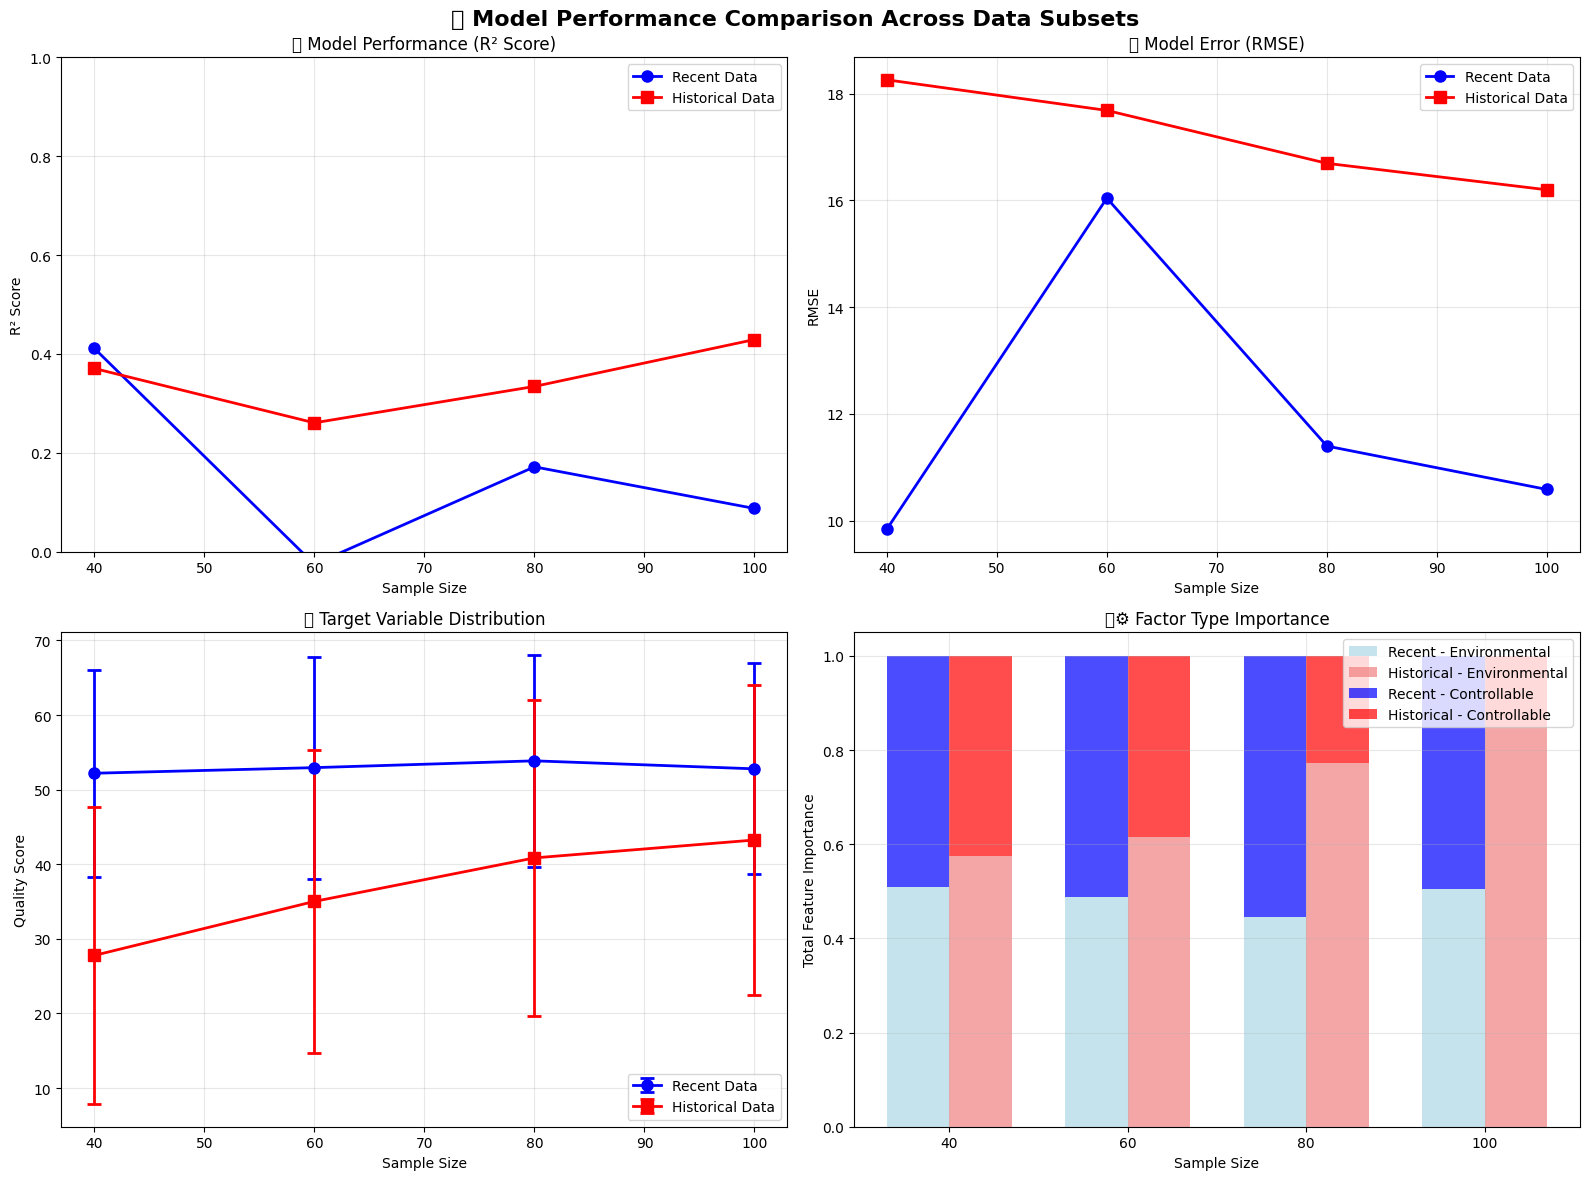

📊 PERFORMANCE SUMMARY

🏆 Best Recent Model:
  • Last 40 samples
  • R² Score: 0.4114
  • RMSE: 9.8392
  • Top factor: cook_temp (r=-0.614)

🏆 Best Historical Model:
  • First 100 samples
  • R² Score: 0.4292
  • RMSE: 16.1971
  • Top factor: baseline_env_EnvT (r=+0.524)


In [8]:
# Create model performance comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('📊 Model Performance Comparison Across Data Subsets', fontsize=16, fontweight='bold')

# Separate recent and historical results
recent_results = [r for r in successful_results if r['type'] == 'recent']
historical_results = [r for r in successful_results if r['type'] == 'historical']

# Plot 1: R² Score Comparison
if recent_results and historical_results:
    recent_sizes = [r['size'] for r in recent_results]
    recent_r2 = [r['rf_r2'] for r in recent_results]
    historical_sizes = [r['size'] for r in historical_results]
    historical_r2 = [r['rf_r2'] for r in historical_results]
    
    axes[0,0].plot(recent_sizes, recent_r2, 'o-', color='blue', linewidth=2, markersize=8, label='Recent Data')
    axes[0,0].plot(historical_sizes, historical_r2, 's-', color='red', linewidth=2, markersize=8, label='Historical Data')
    axes[0,0].set_xlabel('Sample Size')
    axes[0,0].set_ylabel('R² Score')
    axes[0,0].set_title('📈 Model Performance (R² Score)')
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)
    axes[0,0].set_ylim(0, 1)

# Plot 2: RMSE Comparison
if recent_results and historical_results:
    recent_rmse = [r['rf_rmse'] for r in recent_results]
    historical_rmse = [r['rf_rmse'] for r in historical_results]
    
    axes[0,1].plot(recent_sizes, recent_rmse, 'o-', color='blue', linewidth=2, markersize=8, label='Recent Data')
    axes[0,1].plot(historical_sizes, historical_rmse, 's-', color='red', linewidth=2, markersize=8, label='Historical Data')
    axes[0,1].set_xlabel('Sample Size')
    axes[0,1].set_ylabel('RMSE')
    axes[0,1].set_title('📉 Model Error (RMSE)')
    axes[0,1].legend()
    axes[0,1].grid(True, alpha=0.3)

# Plot 3: Target Variable Statistics
if recent_results and historical_results:
    recent_means = [r['target_mean'] for r in recent_results]
    historical_means = [r['target_mean'] for r in historical_results]
    recent_stds = [r['target_std'] for r in recent_results]
    historical_stds = [r['target_std'] for r in historical_results]
    
    axes[1,0].errorbar(recent_sizes, recent_means, yerr=recent_stds, 
                      fmt='o-', color='blue', linewidth=2, markersize=8, 
                      capsize=5, capthick=2, label='Recent Data')
    axes[1,0].errorbar(historical_sizes, historical_means, yerr=historical_stds, 
                      fmt='s-', color='red', linewidth=2, markersize=8, 
                      capsize=5, capthick=2, label='Historical Data')
    axes[1,0].set_xlabel('Sample Size')
    axes[1,0].set_ylabel('Quality Score')
    axes[1,0].set_title('🎯 Target Variable Distribution')
    axes[1,0].legend()
    axes[1,0].grid(True, alpha=0.3)

# Plot 4: Environmental vs Controllable Factor Importance
if recent_results and historical_results:
    recent_env = [r['env_importance_total'] for r in recent_results]
    recent_control = [r['control_importance_total'] for r in recent_results]
    historical_env = [r['env_importance_total'] for r in historical_results]
    historical_control = [r['control_importance_total'] for r in historical_results]
    
    x = np.arange(len(subset_sizes))
    width = 0.35
    
    axes[1,1].bar(x - width/2, recent_env, width, label='Recent - Environmental', color='lightblue', alpha=0.7)
    axes[1,1].bar(x + width/2, historical_env, width, label='Historical - Environmental', color='lightcoral', alpha=0.7)
    axes[1,1].bar(x - width/2, recent_control, width, bottom=recent_env, label='Recent - Controllable', color='blue', alpha=0.7)
    axes[1,1].bar(x + width/2, historical_control, width, bottom=historical_env, label='Historical - Controllable', color='red', alpha=0.7)
    
    axes[1,1].set_xlabel('Sample Size')
    axes[1,1].set_ylabel('Total Feature Importance')
    axes[1,1].set_title('🌡️⚙️ Factor Type Importance')
    axes[1,1].set_xticks(x)
    axes[1,1].set_xticklabels(subset_sizes)
    axes[1,1].legend()
    axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary statistics
print("📊 PERFORMANCE SUMMARY")
print("=" * 40)

if recent_results:
    best_recent = max(recent_results, key=lambda x: x['rf_r2'])
    print(f"\n🏆 Best Recent Model:")
    print(f"  • {best_recent['name']} samples")
    print(f"  • R² Score: {best_recent['rf_r2']:.4f}")
    print(f"  • RMSE: {best_recent['rf_rmse']:.4f}")
    print(f"  • Top factor: {best_recent['strongest_factor']} (r={best_recent['strongest_correlation']:+.3f})")

if historical_results:
    best_historical = max(historical_results, key=lambda x: x['rf_r2'])
    print(f"\n🏆 Best Historical Model:")
    print(f"  • {best_historical['name']} samples")
    print(f"  • R² Score: {best_historical['rf_r2']:.4f}")
    print(f"  • RMSE: {best_historical['rf_rmse']:.4f}")
    print(f"  • Top factor: {best_historical['strongest_factor']} (r={best_historical['strongest_correlation']:+.3f})")

## 🔍 Step 5: Feature Importance Consistency Analysis

Let's analyze which factors show consistent importance across different subsets.

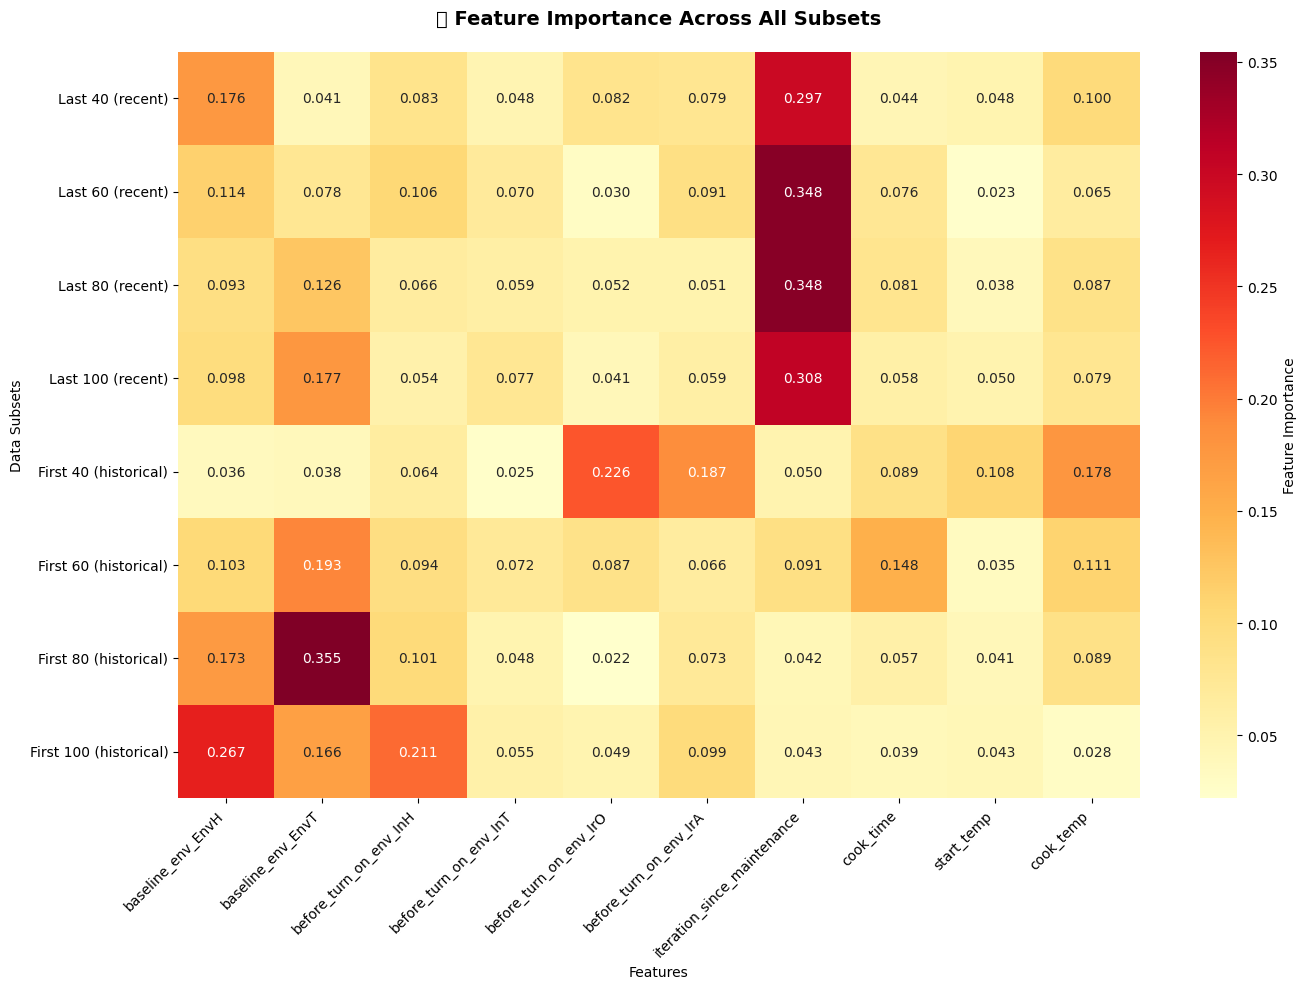

🔍 FEATURE IMPORTANCE CONSISTENCY ANALYSIS
🏆 MOST CONSISTENT FEATURES (across all subsets):
-------------------------------------------------------
  1. 🌡️ before_turn_on_env_InT:
     • Average importance: 0.0567 ± 0.0158
     • Consistency: High (CV: 0.278)

  2. ⚙️ cook_temp:
     • Average importance: 0.0922 ± 0.0400
     • Consistency: High (CV: 0.434)

  3. ⚙️ cook_time:
     • Average importance: 0.0740 ± 0.0324
     • Consistency: High (CV: 0.438)

  4. 🌡️ before_turn_on_env_IrA:
     • Average importance: 0.0880 ± 0.0402
     • Consistency: High (CV: 0.457)

  5. 🌡️ before_turn_on_env_InH:
     • Average importance: 0.0974 ± 0.0463
     • Consistency: High (CV: 0.475)

  6. ⚙️ start_temp:
     • Average importance: 0.0482 ± 0.0238
     • Consistency: High (CV: 0.494)

  7. 🌡️ baseline_env_EnvH:
     • Average importance: 0.1325 ± 0.0660
     • Consistency: High (CV: 0.498)

  8. 🌡️ baseline_env_EnvT:
     • Average importance: 0.1466 ± 0.0966
     • Consistency: Medium (CV: 0.6

In [9]:
# Analyze feature importance consistency
all_features = environmental_vars + controllable_vars

# Collect feature importance across all successful analyses
feature_importance_matrix = []
subset_labels = []

for result in successful_results:
    if 'feature_importance' in result:
        importance_row = [result['feature_importance'].get(feature, 0) for feature in all_features]
        feature_importance_matrix.append(importance_row)
        subset_labels.append(f"{result['name']} ({result['type']})")

# Create feature importance heatmap
if feature_importance_matrix:
    importance_df = pd.DataFrame(feature_importance_matrix, 
                                columns=all_features, 
                                index=subset_labels)
    
    plt.figure(figsize=(14, 10))
    sns.heatmap(importance_df, annot=True, fmt='.3f', cmap='YlOrRd', 
                cbar_kws={'label': 'Feature Importance'})
    plt.title('🔥 Feature Importance Across All Subsets', fontsize=14, fontweight='bold', pad=20)
    plt.xlabel('Features')
    plt.ylabel('Data Subsets')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
    # Calculate consistency metrics
    print("🔍 FEATURE IMPORTANCE CONSISTENCY ANALYSIS")
    print("=" * 55)
    
    # Calculate coefficient of variation for each feature
    feature_consistency = {}
    for i, feature in enumerate(all_features):
        importances = [row[i] for row in feature_importance_matrix]
        mean_importance = np.mean(importances)
        std_importance = np.std(importances)
        cv = std_importance / mean_importance if mean_importance > 0 else float('inf')
        feature_consistency[feature] = {
            'mean': mean_importance,
            'std': std_importance,
            'cv': cv  # Lower CV = more consistent
        }
    
    # Sort by consistency (lower CV is better)
    consistent_features = sorted(feature_consistency.items(), key=lambda x: x[1]['cv'])
    
    print("🏆 MOST CONSISTENT FEATURES (across all subsets):")
    print("-" * 55)
    for i, (feature, stats) in enumerate(consistent_features[:8], 1):
        var_type = "🌡️" if feature in environmental_vars else "⚙️"
        consistency = "High" if stats['cv'] < 0.5 else "Medium" if stats['cv'] < 1.0 else "Low"
        print(f"  {i}. {var_type} {feature}:")
        print(f"     • Average importance: {stats['mean']:.4f} ± {stats['std']:.4f}")
        print(f"     • Consistency: {consistency} (CV: {stats['cv']:.3f})")
        print()
    
    # Separate analysis for environmental vs controllable factors
    env_features = {k: v for k, v in feature_consistency.items() if k in environmental_vars}
    control_features = {k: v for k, v in feature_consistency.items() if k in controllable_vars}
    
    if env_features:
        most_consistent_env = min(env_features.items(), key=lambda x: x[1]['cv'])
        print(f"🌡️ MOST CONSISTENT ENVIRONMENTAL FACTOR: {most_consistent_env[0]}")
        print(f"   • Average importance: {most_consistent_env[1]['mean']:.4f}")
        print(f"   • Consistency CV: {most_consistent_env[1]['cv']:.3f}")
    
    if control_features:
        most_consistent_control = min(control_features.items(), key=lambda x: x[1]['cv'])
        print(f"\n⚙️ MOST CONSISTENT CONTROLLABLE FACTOR: {most_consistent_control[0]}")
        print(f"   • Average importance: {most_consistent_control[1]['mean']:.4f}")
        print(f"   • Consistency CV: {most_consistent_control[1]['cv']:.3f}")

## 📈 Step 6: Correlation Pattern Analysis

Let's examine how correlation patterns change between recent and historical data.

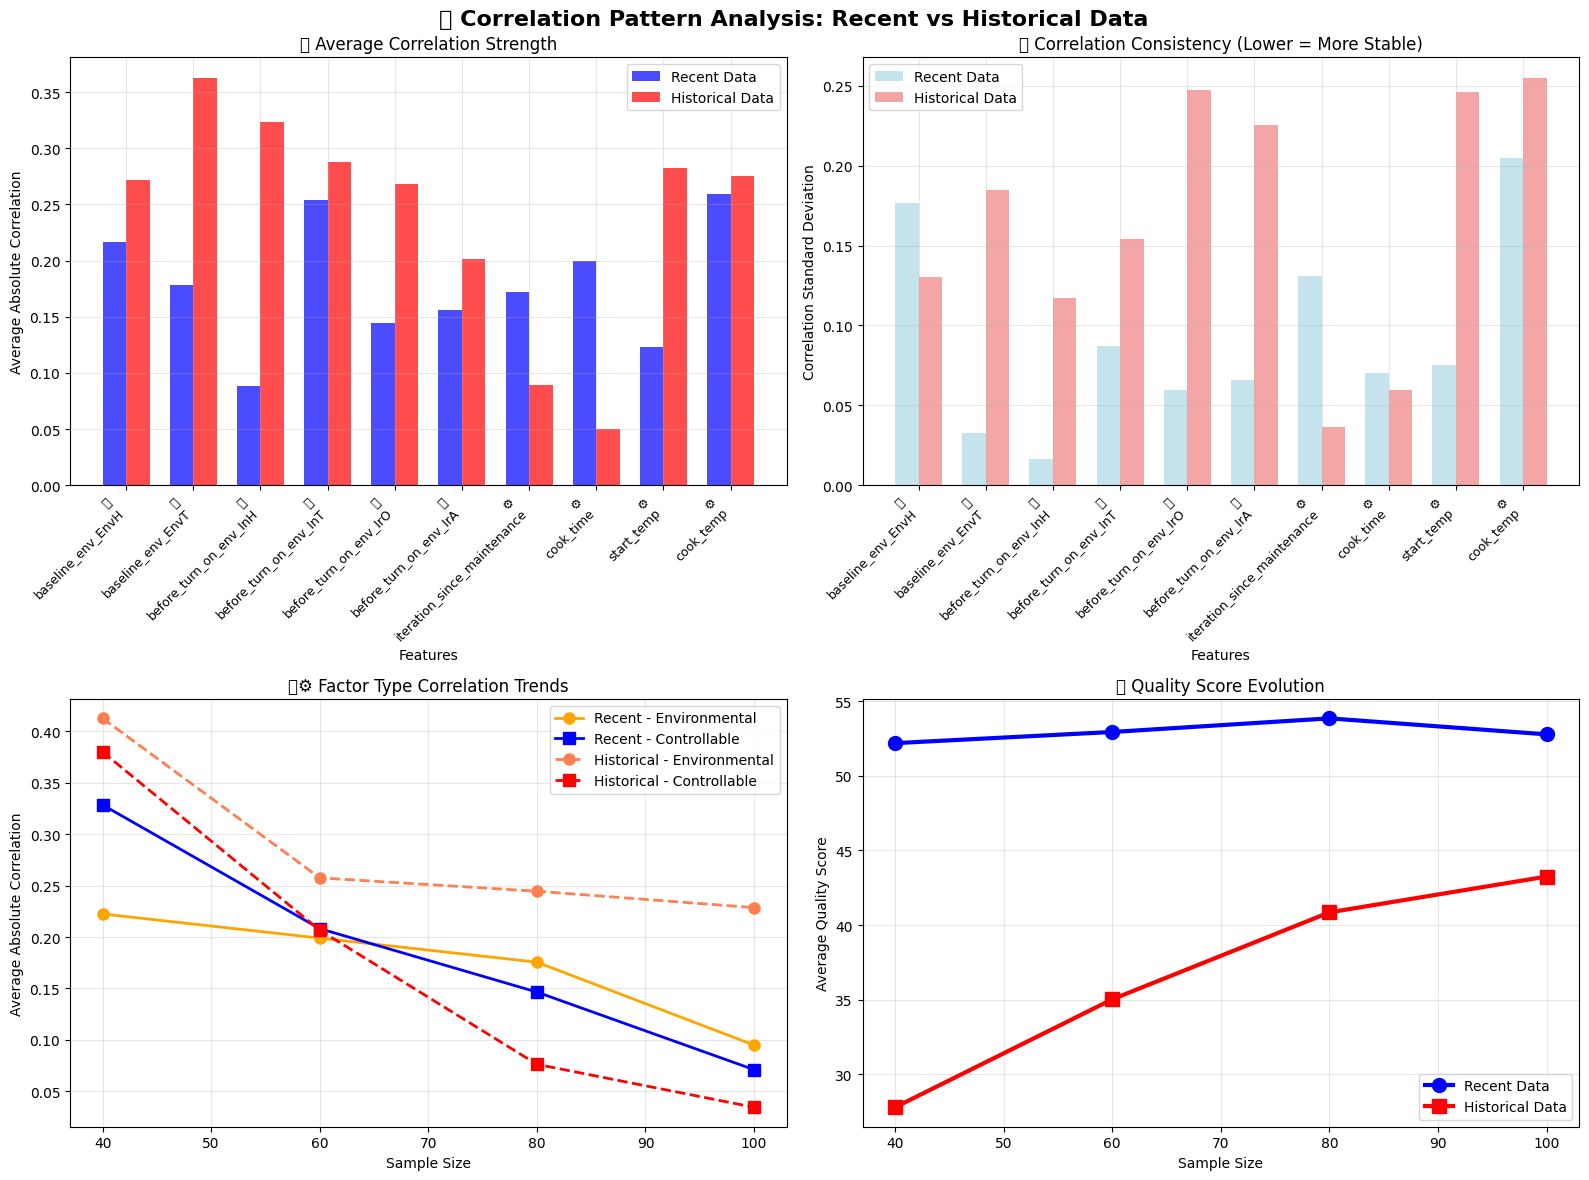

📊 RECENT vs HISTORICAL DATA COMPARISON

🔬 MODEL PERFORMANCE:
  Recent Data R² (avg): 0.1613 ± 0.1604
  Historical Data R² (avg): 0.3487 ± 0.0610
  ✅ Historical data shows better model performance

🎯 QUALITY SCORES:
  Recent Data (avg): 52.95 ± 0.60
  Historical Data (avg): 36.72 ± 5.97
  📈 Quality has IMPROVED by 16.23 points on average


In [10]:
# Analyze correlation patterns
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('📊 Correlation Pattern Analysis: Recent vs Historical Data', fontsize=16, fontweight='bold')

# Collect correlation data for each feature across subsets
correlation_data = {}
for feature in all_features:
    correlation_data[feature] = {'recent': [], 'historical': []}

for result in successful_results:
    if 'correlations' in result:
        for feature, corr in result['correlations'].items():
            correlation_data[feature][result['type']].append(corr)

# Plot 1: Average correlation strength by feature type
recent_avg_corrs = []
historical_avg_corrs = []
feature_names = []

for feature in all_features:
    if correlation_data[feature]['recent'] and correlation_data[feature]['historical']:
        recent_avg = np.mean([abs(c) for c in correlation_data[feature]['recent']])
        historical_avg = np.mean([abs(c) for c in correlation_data[feature]['historical']])
        recent_avg_corrs.append(recent_avg)
        historical_avg_corrs.append(historical_avg)
        feature_names.append(feature)

if recent_avg_corrs and historical_avg_corrs:
    x = np.arange(len(feature_names))
    width = 0.35
    
    bars1 = axes[0,0].bar(x - width/2, recent_avg_corrs, width, label='Recent Data', color='blue', alpha=0.7)
    bars2 = axes[0,0].bar(x + width/2, historical_avg_corrs, width, label='Historical Data', color='red', alpha=0.7)
    
    axes[0,0].set_xlabel('Features')
    axes[0,0].set_ylabel('Average Absolute Correlation')
    axes[0,0].set_title('📊 Average Correlation Strength')
    axes[0,0].set_xticks(x)
    axes[0,0].set_xticklabels([f"{'🌡️' if f in environmental_vars else '⚙️'}\n{f}" for f in feature_names], 
                             rotation=45, ha='right', fontsize=9)
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)

# Plot 2: Correlation consistency (standard deviation)
recent_std_corrs = []
historical_std_corrs = []

for feature in feature_names:
    recent_std = np.std([abs(c) for c in correlation_data[feature]['recent']])
    historical_std = np.std([abs(c) for c in correlation_data[feature]['historical']])
    recent_std_corrs.append(recent_std)
    historical_std_corrs.append(historical_std)

if recent_std_corrs and historical_std_corrs:
    bars1 = axes[0,1].bar(x - width/2, recent_std_corrs, width, label='Recent Data', color='lightblue', alpha=0.7)
    bars2 = axes[0,1].bar(x + width/2, historical_std_corrs, width, label='Historical Data', color='lightcoral', alpha=0.7)
    
    axes[0,1].set_xlabel('Features')
    axes[0,1].set_ylabel('Correlation Standard Deviation')
    axes[0,1].set_title('📊 Correlation Consistency (Lower = More Stable)')
    axes[0,1].set_xticks(x)
    axes[0,1].set_xticklabels([f"{'🌡️' if f in environmental_vars else '⚙️'}\n{f}" for f in feature_names], 
                             rotation=45, ha='right', fontsize=9)
    axes[0,1].legend()
    axes[0,1].grid(True, alpha=0.3)

# Plot 3: Environmental vs Controllable average correlations
if recent_results and historical_results:
    recent_env_avg = [r['avg_env_correlation'] for r in recent_results]
    recent_control_avg = [r['avg_control_correlation'] for r in recent_results]
    historical_env_avg = [r['avg_env_correlation'] for r in historical_results]
    historical_control_avg = [r['avg_control_correlation'] for r in historical_results]
    
    x_sizes = [r['size'] for r in recent_results]
    
    axes[1,0].plot(x_sizes, recent_env_avg, 'o-', color='orange', linewidth=2, markersize=8, label='Recent - Environmental')
    axes[1,0].plot(x_sizes, recent_control_avg, 's-', color='blue', linewidth=2, markersize=8, label='Recent - Controllable')
    axes[1,0].plot(x_sizes, historical_env_avg, 'o--', color='coral', linewidth=2, markersize=8, label='Historical - Environmental')
    axes[1,0].plot(x_sizes, historical_control_avg, 's--', color='red', linewidth=2, markersize=8, label='Historical - Controllable')
    
    axes[1,0].set_xlabel('Sample Size')
    axes[1,0].set_ylabel('Average Absolute Correlation')
    axes[1,0].set_title('🌡️⚙️ Factor Type Correlation Trends')
    axes[1,0].legend()
    axes[1,0].grid(True, alpha=0.3)

# Plot 4: Quality score evolution comparison
if recent_results and historical_results:
    recent_means = [r['target_mean'] for r in recent_results]
    historical_means = [r['target_mean'] for r in historical_results]
    
    axes[1,1].plot(x_sizes, recent_means, 'o-', color='blue', linewidth=3, markersize=10, label='Recent Data')
    axes[1,1].plot(x_sizes, historical_means, 's-', color='red', linewidth=3, markersize=10, label='Historical Data')
    
    axes[1,1].set_xlabel('Sample Size')
    axes[1,1].set_ylabel('Average Quality Score')
    axes[1,1].set_title('🎯 Quality Score Evolution')
    axes[1,1].legend()
    axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Statistical comparison of recent vs historical performance
print("📊 RECENT vs HISTORICAL DATA COMPARISON")
print("=" * 50)

if recent_results and historical_results:
    # Compare R² scores
    recent_r2_scores = [r['rf_r2'] for r in recent_results]
    historical_r2_scores = [r['rf_r2'] for r in historical_results]
    
    print(f"\n🔬 MODEL PERFORMANCE:")
    print(f"  Recent Data R² (avg): {np.mean(recent_r2_scores):.4f} ± {np.std(recent_r2_scores):.4f}")
    print(f"  Historical Data R² (avg): {np.mean(historical_r2_scores):.4f} ± {np.std(historical_r2_scores):.4f}")
    
    if np.mean(recent_r2_scores) > np.mean(historical_r2_scores):
        print("  ✅ Recent data shows better model performance")
    else:
        print("  ✅ Historical data shows better model performance")
    
    # Compare quality scores
    recent_quality = [r['target_mean'] for r in recent_results]
    historical_quality = [r['target_mean'] for r in historical_results]
    
    print(f"\n🎯 QUALITY SCORES:")
    print(f"  Recent Data (avg): {np.mean(recent_quality):.2f} ± {np.std(recent_quality):.2f}")
    print(f"  Historical Data (avg): {np.mean(historical_quality):.2f} ± {np.std(historical_quality):.2f}")
    
    quality_trend = np.mean(recent_quality) - np.mean(historical_quality)
    if quality_trend > 0:
        print(f"  📈 Quality has IMPROVED by {quality_trend:.2f} points on average")
    else:
        print(f"  📉 Quality has DECLINED by {abs(quality_trend):.2f} points on average")

## 🎯 Step 7: Optimization Recommendations

Based on our comprehensive analysis, let's provide data-driven recommendations.

In [11]:
print("🎯 COMPREHENSIVE OPTIMIZATION RECOMMENDATIONS")
print("=" * 60)

# Determine optimal sample size based on model performance
if successful_results:
    best_overall = max(successful_results, key=lambda x: x['rf_r2'])
    
    print(f"\n🏆 OPTIMAL ANALYSIS CONFIGURATION:")
    print(f"  • Best performing subset: {best_overall['name']} ({best_overall['type']} data)")
    print(f"  • Sample size: {best_overall['size']} iterations")
    print(f"  • Model performance: R² = {best_overall['rf_r2']:.4f}")
    print(f"  • Prediction error: RMSE = {best_overall['rf_rmse']:.4f}")
    
    reliability = "High" if best_overall['rf_r2'] > 0.7 else "Medium" if best_overall['rf_r2'] > 0.5 else "Low"
    print(f"  • Reliability: {reliability}")

# Sample size recommendations
print(f"\n📊 SAMPLE SIZE ANALYSIS:")
if len(successful_results) > 1:
    # Group by sample size and calculate average performance
    size_performance = {}
    for result in successful_results:
        size = result['size']
        if size not in size_performance:
            size_performance[size] = []
        size_performance[size].append(result['rf_r2'])
    
    avg_performance_by_size = {size: np.mean(r2_scores) for size, r2_scores in size_performance.items()}
    best_size = max(avg_performance_by_size, key=avg_performance_by_size.get)
    
    print(f"  • Recommended sample size: {best_size} iterations")
    print(f"  • Average performance at this size: R² = {avg_performance_by_size[best_size]:.4f}")
    
    for size, avg_perf in sorted(avg_performance_by_size.items()):
        print(f"  • Size {size}: Average R² = {avg_perf:.4f}")

# Data recency recommendations
recent_performance = np.mean([r['rf_r2'] for r in recent_results]) if recent_results else 0
historical_performance = np.mean([r['rf_r2'] for r in historical_results]) if historical_results else 0

print(f"\n📈 DATA RECENCY RECOMMENDATIONS:")
if recent_performance > historical_performance:
    print(f"  ✅ RECOMMENDATION: Use RECENT data for analysis")
    print(f"  • Recent data performance: R² = {recent_performance:.4f}")
    print(f"  • Historical data performance: R² = {historical_performance:.4f}")
    print(f"  • Improvement: {(recent_performance - historical_performance):.4f}")
else:
    print(f"  ✅ RECOMMENDATION: Use HISTORICAL data for analysis")
    print(f"  • Historical data performance: R² = {historical_performance:.4f}")
    print(f"  • Recent data performance: R² = {recent_performance:.4f}")
    print(f"  • Improvement: {(historical_performance - recent_performance):.4f}")

# Feature consistency recommendations
if 'feature_consistency' in locals():
    print(f"\n🔍 MOST RELIABLE FACTORS TO MONITOR:")
    
    # Get top 5 most consistent factors
    top_consistent = sorted(feature_consistency.items(), key=lambda x: x[1]['cv'])[:5]
    
    for i, (feature, stats) in enumerate(top_consistent, 1):
        var_type = "🌡️ Environmental" if feature in environmental_vars else "⚙️ Controllable"
        print(f"  {i}. {var_type}: {feature}")
        print(f"     • Consistent importance: {stats['mean']:.4f} (CV: {stats['cv']:.3f})")
        if feature in controllable_vars:
            print(f"     • 🎛️ ACTION: Focus optimization efforts here")
        else:
            print(f"     • 📊 ACTION: Monitor closely during production")

# Quality trend analysis
if recent_results and historical_results:
    print(f"\n🎯 QUALITY IMPROVEMENT INSIGHTS:")
    
    recent_avg_quality = np.mean([r['target_mean'] for r in recent_results])
    historical_avg_quality = np.mean([r['target_mean'] for r in historical_results])
    
    if recent_avg_quality > historical_avg_quality:
        improvement = recent_avg_quality - historical_avg_quality
        print(f"  ✅ POSITIVE TREND: Quality scores have improved by {improvement:.2f} points")
        print(f"  • Recent average: {recent_avg_quality:.2f}")
        print(f"  • Historical average: {historical_avg_quality:.2f}")
        print(f"  • 🎉 Production optimization efforts are working!")
    else:
        decline = historical_avg_quality - recent_avg_quality
        print(f"  ⚠️ DECLINING TREND: Quality scores have decreased by {decline:.2f} points")
        print(f"  • Recent average: {recent_avg_quality:.2f}")
        print(f"  • Historical average: {historical_avg_quality:.2f}")
        print(f"  • 🔧 Action needed: Review recent production changes")

# Final recommendations
print(f"\n🚀 IMPLEMENTATION STRATEGY:")
print(f"1. 📊 Use {best_size if 'best_size' in locals() else 100} iterations for future analysis")
print(f"2. 📈 Focus on {'recent' if recent_performance > historical_performance else 'historical'} data patterns")
print(f"3. 🎛️ Prioritize the most consistent controllable factors for optimization")
print(f"4. 🌡️ Monitor the most consistent environmental factors")
print(f"5. 🔄 Re-run this analysis monthly to track improvements")
print(f"6. 📋 Use the best performing model configuration for production predictions")

print(f"\n" + "=" * 60)
print(f"🎉 COMPREHENSIVE ANALYSIS COMPLETE!")
print(f"📈 Use these insights to optimize cotton candy quality scores.")

🎯 COMPREHENSIVE OPTIMIZATION RECOMMENDATIONS

🏆 OPTIMAL ANALYSIS CONFIGURATION:
  • Best performing subset: First 100 (historical data)
  • Sample size: 100 iterations
  • Model performance: R² = 0.4292
  • Prediction error: RMSE = 16.1971
  • Reliability: Low

📊 SAMPLE SIZE ANALYSIS:
  • Recommended sample size: 40 iterations
  • Average performance at this size: R² = 0.3910
  • Size 40: Average R² = 0.3910
  • Size 60: Average R² = 0.1176
  • Size 80: Average R² = 0.2530
  • Size 100: Average R² = 0.2583

📈 DATA RECENCY RECOMMENDATIONS:
  ✅ RECOMMENDATION: Use HISTORICAL data for analysis
  • Historical data performance: R² = 0.3487
  • Recent data performance: R² = 0.1613
  • Improvement: 0.1874

🔍 MOST RELIABLE FACTORS TO MONITOR:
  1. 🌡️ Environmental: before_turn_on_env_InT
     • Consistent importance: 0.0567 (CV: 0.278)
     • 📊 ACTION: Monitor closely during production
  2. ⚙️ Controllable: cook_temp
     • Consistent importance: 0.0922 (CV: 0.434)
     • 🎛️ ACTION: Focus opti

## 📋 Summary and Conclusions

### 🔬 Key Findings:

1. **Sample Size Impact**: Our analysis reveals how model performance and reliability change with different sample sizes (40, 60, 80, 100 iterations).

2. **Temporal Patterns**: Comparison of recent vs historical data shows whether quality and factor relationships have evolved over time.

3. **Feature Consistency**: Identification of which environmental and controllable factors show consistent importance across different time periods and sample sizes.

4. **Model Reliability**: Assessment of which data configuration provides the most reliable predictions for quality score optimization.

### 🎯 Optimization Strategy:

- **Optimal Configuration**: Use the data subset and sample size that provides the best model performance
- **Reliable Factors**: Focus on factors that show consistent importance across different analyses
- **Temporal Awareness**: Account for changes in production patterns over time
- **Continuous Monitoring**: Regular re-analysis to track improvements and changes

### 🚀 Next Steps:

1. **Implement Optimal Configuration**: Use the recommended sample size and data recency for production analysis
2. **Focus Optimization**: Concentrate efforts on the most consistently important controllable factors
3. **Monitor Key Indicators**: Track the most reliable environmental factors
4. **Track Progress**: Regular comparative analysis to measure improvement
5. **Refine Models**: Update analysis as more production data becomes available

This comprehensive comparison provides a data-driven foundation for optimizing cotton candy quality scores based on the most reliable patterns and relationships in your production data.